In [12]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model, Integrated_Model_RNN
import RNN as RNN

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


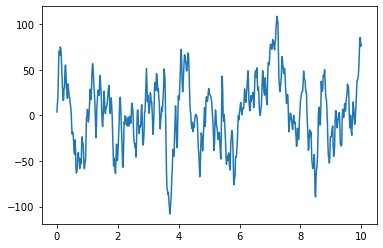

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered (dvariance)--------
X_train: shape of(1387, 28, 31)
X_test: shape of(1487, 28, 31)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


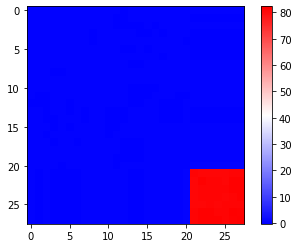

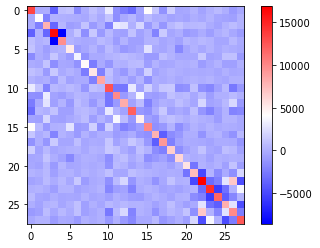

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

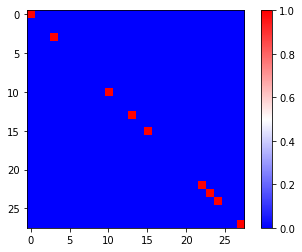

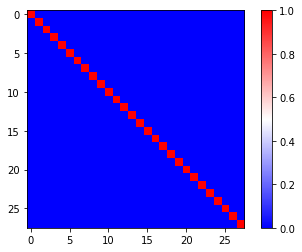

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

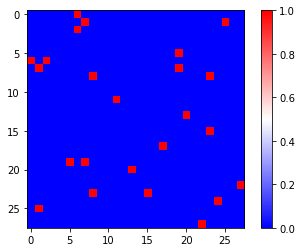

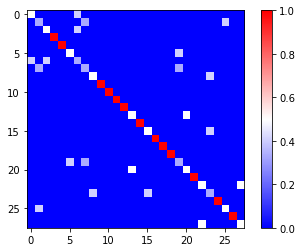

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

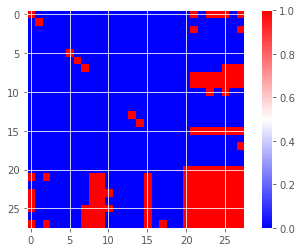

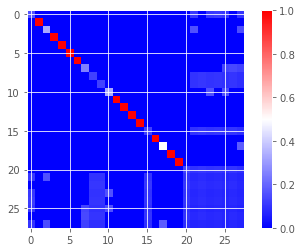

In [54]:
n = 8*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [117]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
RNNparametersGCN = {
    'hidden_dim' : 10,
    'batch_size': 128,
    'num_epochs': 150,
    'learning_rate': 6e-3,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
RNNparametersGDE = {
    'hidden_dim' : 10,
    'batch_size': 128,
    'num_epochs': 250,
    'learning_rate': 6e-3,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

In [118]:
IM = Integrated_Model_RNN(GCNparameters, GDEparameters, RNNparametersGCN, RNNparametersGDE, dm, create_DAD(Araw))

  0%|          | 0/11 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 501.228759765625   Valid loss: 500.524719238281259
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


  9%|▉         | 1/11 [00:00<00:01,  5.54it/s]

Epoch: 1   Batch: 1 of size 128   Train loss: 506.38800048828125   Valid loss: 505.16961669921875

 27%|██▋       | 3/11 [00:00<00:01,  5.55it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.60it/s]

Epoch: 1   Batch: 4 of size 128   Train loss: 502.8316345214844   Valid loss: 502.0295104980469

 55%|█████▍    | 6/11 [00:01<00:00,  5.59it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.67it/s]

Epoch: 1   Batch: 7 of size 128   Train loss: 499.82379150390625   Valid loss: 499.54156494140625

 73%|███████▎  | 8/11 [00:01<00:00,  5.57it/s]

Epoch:atch: 8 of size 128   Train loss: 499.18621826171875   Valid loss: 499.0136413574219

 91%|█████████ | 10/11 [00:01<00:00,  5.60it/s]

100%|██████████| 11/11 [00:01<00:00,  5.61it/s]


Epoch: 1   Batch: 11 of size 128   Train loss: 497.7989807128906   Valid loss: 497.79718017578125
----------Training Ends-----------
----------Training RNN-----------
Epoch: 1   Train loss: 0.6943   Train accuracy: 0.471   Val loss: 0.6256   Val accuracy: 0.632    weighted Val loss: 0.6256
0.632 ----------saved-----------
Epoch: 2   Train loss: 0.6096   Train accuracy: 0.609   Val loss: 0.5642   Val accuracy: 0.687    weighted Val loss: 0.6252
0.687 ----------saved-----------
Epoch: 3   Train loss: 0.5366   Train accuracy: 0.685   Val loss: 0.5104   Val accuracy: 0.704    weighted Val loss: 0.6247
0.704 ----------saved-----------
Epoch: 4   Train loss: 0.4718   Train accuracy: 0.723   Val loss: 0.4653   Val accuracy: 0.713    weighted Val loss: 0.6239
0.713 ----------saved-----------
Epoch: 5   Train loss: 0.4167   Train accuracy: 0.748   Val loss: 0.4301   Val accuracy: 0.721    weighted Val loss: 0.6229
0.721 ----------saved-----------
Epoch: 6   Train loss: 0.3722   Train accuracy: 

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.1088 F1 accuracy 0.849 Precision accuracy 0.738 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.1  validation loss: 0.1088 F1 accuracy 0.851 Precision accuracy 0.74 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.15  validation loss: 0.1088 F1 accuracy 0.858 Precision accuracy 0.752 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.2  validation loss: 0.1088 F1 accuracy 0.858 Precision accuracy 0.752 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.25  validation loss: 0.1088 F1 accuracy 0.86 Precision accuracy 0.755 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.3  validation loss: 0.1088 F1 accuracy 0.864 Precision accuracy 0.761 Recall accuracy 1.0 AUC accuracy: 0.988
device set to cuda
threshold: 0.35  validation loss: 0.1088 F1 accuracy 0.864 Precision accuracy 0.761 Recall accuracy 1.0 AUC accura

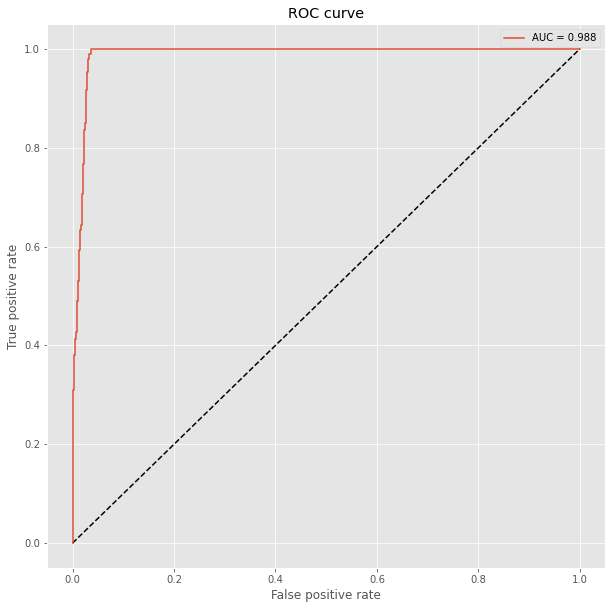

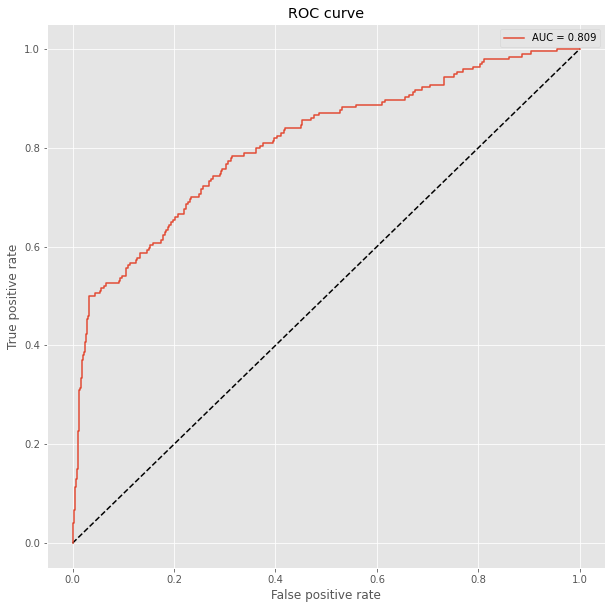

In [119]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')

In [90]:
def save_ckp(state, f_path):
    torch.save(state, f_path)
    print("model saved")
def load_ckp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    return checkpoint
def load_RNNmodel(checkpoint, device_name ='cpu' ):
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    
    parameters = checkpoint['parameters']
    model = RNN.RNN(dm.A_train.shape[1], 1, parameters['hidden_dim'], device = device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],
                                 weight_decay=parameters['weight_decay'])
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [120]:
#save_ckp(IM.RNNcheckpointGDE, "models/best_##DERNNmodel.pt")
#save_ckp(IM.GDEcheckpoint, "models/best_GDEmodel.pt")
save_ckp(IM.RNNcheckpointGCN, "models/best_GCNRNNmodel.pt")
save_ckp(IM.GCNcheckpoint, "models/best_GCNmodel.pt") 

model saved
model saved


In [113]:
#try loading the model
checkpoint = load_ckp("models/best_GCNRNNmodel.pt")
RNNmodel, RNNoptimizer = load_RNNmodel(checkpoint, device_name ='cuda' )

device set to cuda


In [114]:
IM.RNNmodelGCN = RNNmodel

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.5352 F1 accuracy 0.197 Precision accuracy 0.759 Recall accuracy 0.113 AUC accuracy: 0.742
device set to cuda
threshold: 0.1  validation loss: 0.5352 F1 accuracy 0.164 Precision accuracy 0.72 Recall accuracy 0.093 AUC accuracy: 0.742
device set to cuda
threshold: 0.15  validation loss: 0.5352 F1 accuracy 0.157 Precision accuracy 0.773 Recall accuracy 0.088 AUC accuracy: 0.742
device set to cuda
threshold: 0.2  validation loss: 0.5352 F1 accuracy 0.123 Precision accuracy 0.765 Recall accuracy 0.067 AUC accuracy: 0.742
device set to cuda
threshold: 0.25  validation loss: 0.5352 F1 accuracy 0.124 Precision accuracy 0.867 Recall accuracy 0.067 AUC accuracy: 0.742
device set to cuda
threshold: 0.3  validation loss: 0.5352 F1 accuracy 0.098 Precision accuracy 1.0 Recall accuracy 0.052 AUC accuracy: 0.742
device set to cuda
threshold: 0.35  validation loss: 0.5352 F1 accuracy 0.098 Precision accuracy 1.0 Recall accuracy 0.052

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold: 0.6  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.65  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.7  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.75  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.8  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.85  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.9  validation loss: 0.5352 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.742
device set to cuda
threshold: 0.95  validation los

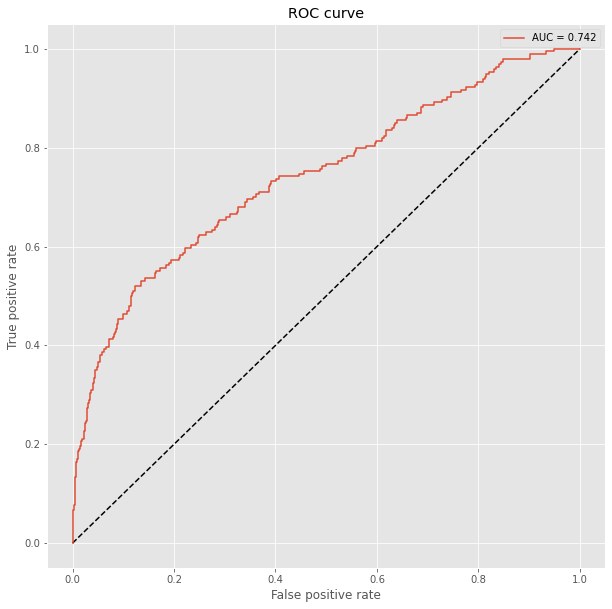

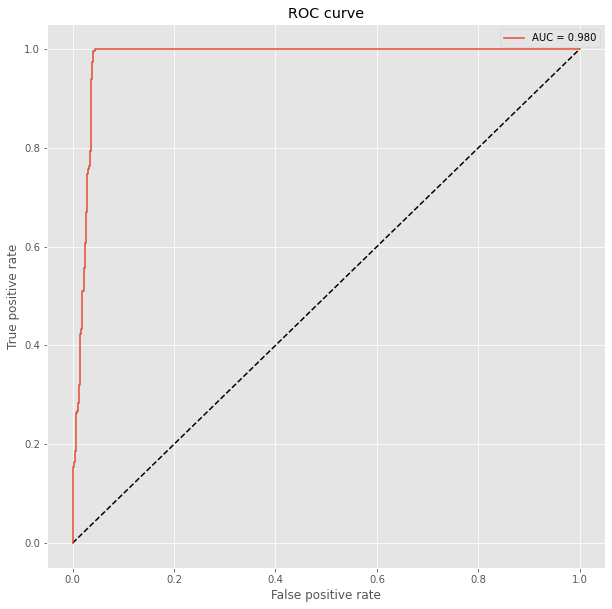

In [115]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')